In [2]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# cosmology
import pyccl as ccl


In [3]:
## EXAMPLE1: example of how to import power spectrum

"""
# import data P(k) and k for some simulation

with open('/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat',"r") as data:
    d = np.loadtxt(data)
    d = np.transpose(d)
    z = d[0]
    k = d[1]
    Pk = d[2]

plt.plot(k[:288],Pk[:288])
plt.xscale('log')
plt.yscale('log')

del d, z, k, Pk
"""

'\n# import data P(k) and k for some simulation\n\nwith open(\'/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat\',"r") as data:\n    d = np.loadtxt(data)\n    d = np.transpose(d)\n    z = d[0]\n    k = d[1]\n    Pk = d[2]\n\nplt.plot(k[:288],Pk[:288])\nplt.xscale(\'log\')\nplt.yscale(\'log\')\n\ndel d, z, k, Pk\n'

z is np.linspace(0.001 , 5.0 , int(1e4))

## Find binned redshift distribution (define z and output Binned_distribution(z))

In [4]:
""" Get a binned redshift distribution - defining functions """

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    
    alpha = 1.27
    beta = 1.02
    z0 = 0.5
    pz = z**alpha * np.exp(-(z / z0)**beta)                                # Redshift distribution, p(z)
    return pz

# complete binning of z so that integral of redshiftdist(z) between bins stays the same. Need redshiftdist(z) to be Normalized
# (in limit of large z linspace)

def bindist(z, n_bins):
                                                                          # have redshiftdist(z), z 
                                                                          # find bins: integrate between 0 and i redshift(z)
                                                                          #            if integral => 1/n_bin, that is a bin
                                                                          #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

# define gaussian photo-z uncertainties

def gaussianphotoz(zs , zp):
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

# bins distribution for redshiftdist(z) in n_bins with same number of galaxies in each bin, smoothened by gaussianphotoz(zs , zp) kernel

def binning_redshiftdist(z , n_bins):
    
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel

    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [5]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.01 , 5.0 , int(1e4))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 10)[0]

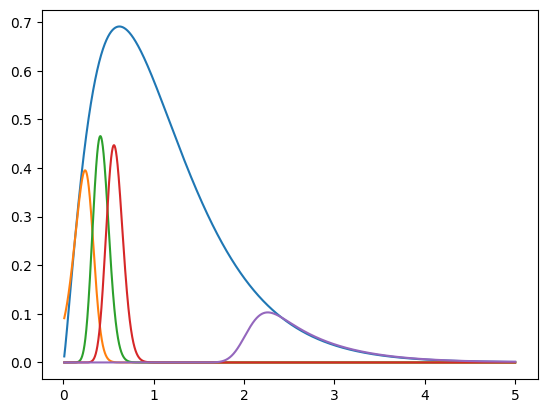

In [6]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[9])


## Finding C_ell

In [7]:
""" Finding C_ell_array (our training data) - defining function """

def findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, cosmo_MCMC, z, Binned_distribution):
    
    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
    
    # define quantities for binning C_ell
    
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    ell_binned = list(islice(cycle(ell_binned), 990))
    
    B_data = np.zeros((len(cosmo),int(ell_bin_num*((len(Binned_distribution) + 1) * len(Binned_distribution) / 2))))
    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for i in range(len(cosmo)):
        C_ell_array = []
        
        def pk_func(k, a):
            pk_lin = ccl.linear_matter_power(cosmo[i], k, a=a)
            pk_nl = ccl.nonlin_matter_power(cosmo[i], k=k, a=a)
            pk_fid = ccl.linear_matter_power(cosmo_MCMC, k, a=a)
            P_delta = (pk_nl/pk_lin) * pk_fid
            return P_delta
        
        P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)
        
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[j]))        # TODO normalization
                tracer2 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmo[i], tracer1, tracer2, ell, p_of_k_a=P_delta2D)        # uses non-linear matter power spectrum stored in `cosmo`

                # bin ell
                bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                               bins= ell_binned_limits)
    
                C_ell_array = np.append(C_ell_array, bin_means)
        B_data[i] = C_ell_array
    return ell_binned, B_data

In [8]:
""" define cosmological parameters """

c = 3e5                                                                  # km/s

cosmo_MCMC = ccl.Cosmology(Omega_c = 0.25, 
                      Omega_b = 0.05, 
                      h = 0.7, 
                      n_s = 0.95,
                      sigma8 = 0.8, 
                      transfer_function='bbks',
                      matter_power_spectrum='linear')

cosmo = np.zeros((3,3) , dtype=object)

for i in range(len(cosmo)):
    for j in range(len(cosmo[0])):
        cosmo[i][j] = ccl.Cosmology(Omega_c = 0.245 + (0.005 * i), 
                      Omega_b = 0.05, 
                      h = 0.7, 
                      n_s = 0.95,
                      sigma8 = 0.75 + 0.05 * j, 
                      transfer_function='bbks')
cosmo = np.append(np.append(cosmo[0] , cosmo[1]) , cosmo[2])

In [9]:
""" Create training data: find P_del for a set of 9 power spectra with different cosmologies """

""" -- NOTES on C_ell --
# redshift distribution is Binned_distribution from above.
# binned over 10 redshift distributions. That means that C_ell[i][j][k] is the C_ell for the ith cosmology, cross correlated over
# jth and kth redshift distribution, as a function of ell."""

# define ell and C_ell shapes 

ell_min = 2
ell_max = 2060

# define quantities for binning of ell

ell_bin_num = 18

# find C_ell for non-linear matter power spectrum

C_ell_data = findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, cosmo_MCMC, z, Binned_distribution)

ell = C_ell_data[0]
B_data = C_ell_data[1]

del C_ell_data

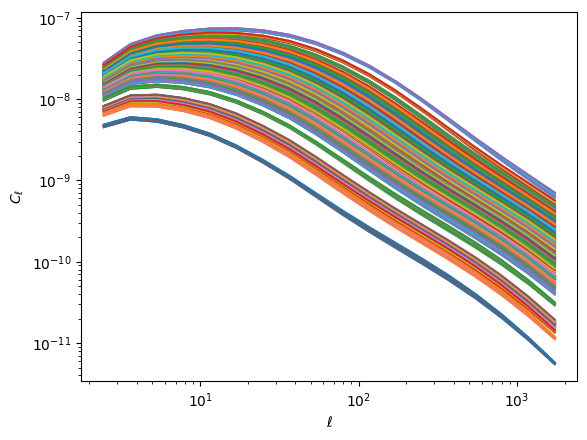

In [10]:
## TEST3: Plot C_ell to see if shapes are reasonable


for i in range(len(B_data)):
    for j in range(int(len(B_data[0])/ell_bin_num)):
        plt.plot(ell[j*18:(j+1)*18], B_data[i][j*18:(j+1)*18])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()



# comment: sigma8 changes the y intercept (as sigma8 increases the value of y-intercept increases
#          OmegaM changes the power spectrum behaviour at high P (as OmegaM increases Cl increases at high l)

In [11]:
""" Finding C_ell_array linear at each MCMC step - defining function """

def findC_ell_array_linear(ell_min, ell_max, ell_bin_num, cosmoMCMC, z, Binned_distribution):

    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
    C_ell_array = []
    
    # define quantities for binning C_ell

    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2

    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for j in range(len(Binned_distribution)):
        for k in range(len(Binned_distribution)):
            if k > j:
                break
            tracer1 = ccl.WeakLensingTracer(cosmo_MCMC, dndz=(z, Binned_distribution[j]))
            tracer2 = ccl.WeakLensingTracer(cosmo_MCMC, dndz=(z, Binned_distribution[k]))
            C_ell = ccl.angular_cl(cosmo_MCMC, tracer1, tracer2, ell)
            
            # bin ell
            bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                           bins= ell_binned_limits)
    
            C_ell_array = np.append(C_ell_array, bin_means)

    return C_ell_array

In [12]:
"""Find C_ell with linear matter power spectrum"""

# ell and C_ell shapes, binning taken from above to be ell_min = 2, ell_max = 2060, ell_bin_num = 18

# find C_ell

M_data = findC_ell_array_linear(ell_min, ell_max, ell_bin_num, cosmo_MCMC, z, Binned_distribution)

Text(0, 0.5, '$\\frac{C^{00}_{NL}(\\ell)}{C^{00}_{Linear}(\\ell)} - 1$')

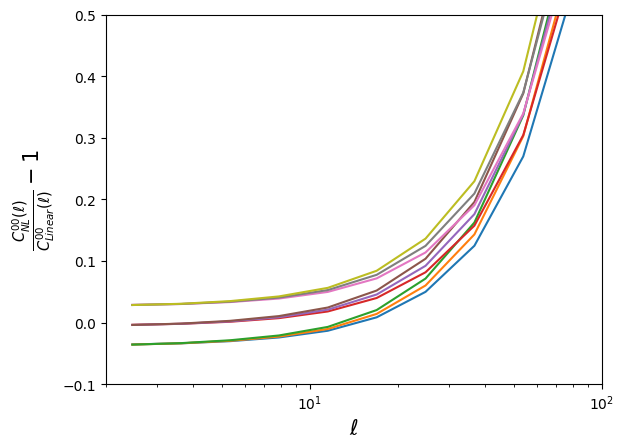

In [13]:
# TEST5: Plot processed data to compare with Huang et al 2020

frac = (B_data / M_data) - 1

plt.xscale('log')
plt.ylim(-0.1,0.5)
plt.xlim(2,1e2)
for i in range(len(cosmo)):
    plt.plot(ell[0:18],frac[i][0:18])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$\frac{C^{00}_{NL}(\ell)}{C^{00}_{Linear}(\ell)} - 1$', size = 15)

Text(0.5, 1.0, 'Cosmology: $\\sigma_8$ = 0.8 + 0.05$j$, $n_s$ = 0.9 + 0.00$i$ \n $\\ell_{min}$ = 2, $\\ell_{max}$ = 2060')

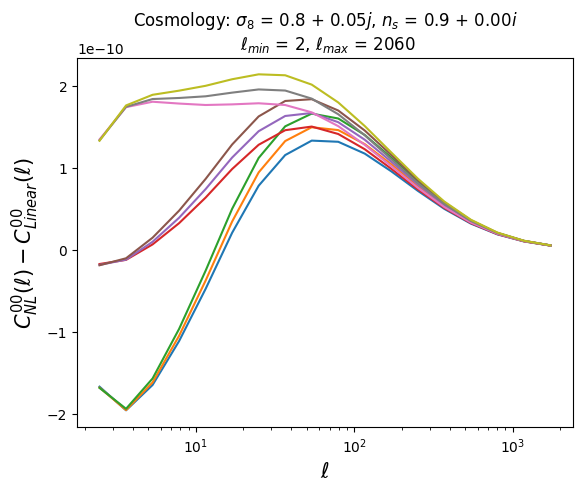

In [14]:
# TEST5: Plot processed data to compare with Huang et al 2020

sub = (B_data - M_data) 

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    plt.plot(ell[0:18],sub[i][0:18])
    
plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
plt.title("Cosmology: $\sigma_8$ = %1.1f + %1.2f$j$, $n_s$ = %1.1f + %1.2f$i$ \n $\ell_{min}$ = %i, $\ell_{max}$ = %i" \
          %(cosmo[0]["sigma8"], cosmo[1]["sigma8"] - cosmo[0]["sigma8"], cosmo[0]["n_s"], cosmo[3]["n_s"] - cosmo[0]["n_s"], ell_min, ell_max))

#plt.savefig('differenceCells.pdf')

## Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [15]:
# Perform PCA with sklearn (Choose n_components to keep)
pca = PCA()

Delta = np.transpose(B_data - M_data)
pca_array = pca.fit_transform(Delta)
Usklearn = np.transpose(pca_array)

In [16]:
# Perform PCA with numpy.linalg.svd
Usvd, s, vh = np.linalg.svd(Delta, full_matrices=True)

In [17]:
def findU_PCAmethod(Delta):
    
    # find eigenvectors and eigenvalues of AAt = Delta*Deltat
    AAt = np.matmul(np.transpose(Delta),Delta)
    eigenvals,eigenvects = np.linalg.eig(AAt)

    eigenvals = eigenvals.real
    eigenvects = eigenvects.real

    # Put eigenvectors and eigenvalues in right order, find U
    composedmatrix = np.array(np.append([eigenvals],np.transpose(eigenvects), axis = 0))
    orderedmatrix = composedmatrix[:, (-composedmatrix)[0].argsort()]
    U = np.transpose(orderedmatrix[1:])
    return U

In [18]:
""" PCA decomposition"""

# Find Delta as 990 rows and 9 columns
print(len(Delta))
Umanual = findU_PCAmethod(np.transpose(Delta))


990


In [19]:
print("manual = ",Umanual)
print("svd = ",Usvd)

manual =  [[ 8.21519653e-03 -2.73502970e-03  3.58674278e-03 ...  3.55661714e-05
   1.29516597e-04  1.29516597e-04]
 [ 1.01685911e-02 -2.43835866e-03  1.17509812e-02 ...  5.70985230e-05
   8.40199183e-05  8.40199183e-05]
 [ 9.68201472e-03 -4.82353660e-04  2.06124738e-02 ...  1.86615618e-04
  -1.50359798e-04 -1.50359798e-04]
 ...
 [ 1.46958152e-02 -4.52713365e-03  9.03848884e-03 ...  4.21248137e-03
  -2.24449270e-03 -2.24449270e-03]
 [ 1.13384580e-02 -3.99973240e-03  1.31567456e-03 ... -1.49233927e-03
   8.95557616e-04  8.95557616e-04]
 [ 1.83691411e-03  1.31152874e-02 -3.77901125e-03 ...  1.38877055e-03
  -2.22244035e-03 -2.22244035e-03]]
svd =  [[-8.21519653e-03 -2.73502970e-03  3.58674278e-03 ...  3.73564852e-02
   2.91199111e-02  2.08755283e-02]
 [-1.01685911e-02 -2.43835866e-03  1.17509812e-02 ... -6.46050523e-02
  -4.76329527e-02 -3.17630635e-02]
 [-9.68201472e-03 -4.82353660e-04  2.06124738e-02 ...  6.13181787e-02
   5.63082750e-02  4.62338168e-02]
 ...
 [-8.81083516e-03  7.456987

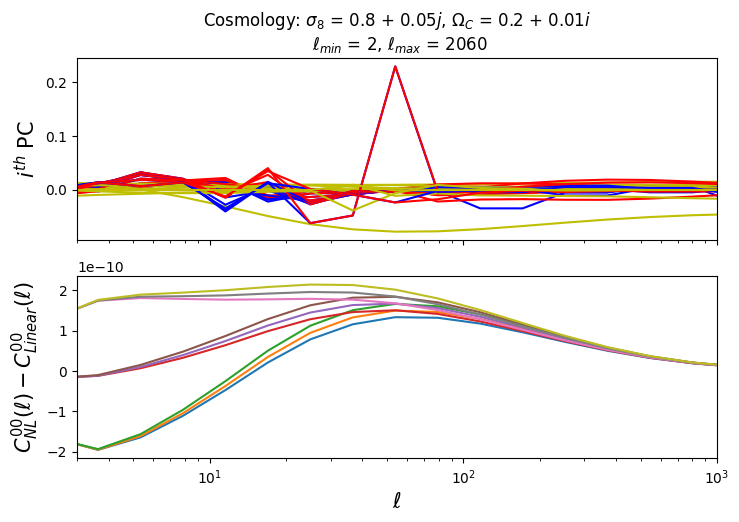

In [20]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False,figsize=(8, 5))

for i in range(9):
    ax1.plot(ell[0:18], Umanual[i][0:18], color = "b", label = "Manual method")
    ax1.plot(ell[0:18], Usvd[i][0: 18], color = "r" , label = "numpy.linalg.svd method")
    ax1.plot(ell[0:18], Usklearn[i][0: 18]/(110*Usklearn[i][0: 18].max()), label = "sklearn method", color = "y")

#plt.legend()
ax1.set_ylabel(r'$i^{th}$ PC', size = 15)
ax1.set_title("Cosmology: $\sigma_8$ = %1.1f + %1.2f$j$, $\Omega_C$ = %1.1f + %1.2f$i$ \n $\ell_{min}$ = %i, $\ell_{max}$ = %i" \
          %(cosmo[0]["sigma8"], cosmo[1]["sigma8"] - cosmo[0]["sigma8"], cosmo[0]["Omega_c"], cosmo[3]["Omega_c"] - cosmo[0]["Omega_c"], ell_min, ell_max))
plt.xscale("log")


#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    ax2.plot(ell[0:18],sub[i][0:18])
    
ax2.set_ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
ax2.set_xlabel(r'$\ell$', size = 15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
#ax1.legend()

ax1.set_xlim(3,1e3)


#plt.savefig('PCcompare.pdf')
plt.show()



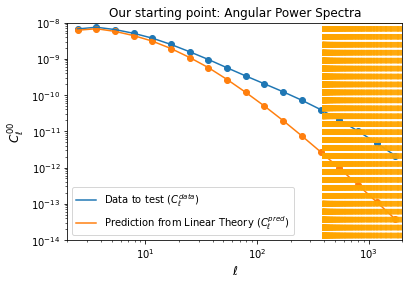

In [58]:
plt.xscale('log')
plt.yscale('log')
plt.plot(ell[0:18],B_data[2][0:18], label = "Data to test ($C^{data}_{\ell}$)")
plt.scatter(ell[0:18],B_data[2][0:18])
plt.plot(ell[0:18],M_data[0:18], label = "Prediction from Linear Theory ($C^{pred}_{\ell})$")
plt.scatter(ell[0:18],M_data[0:18])
plt.xlim(2,2000)
plt.ylim(1e-14,1e-8)

for i in np.logspace(-2,0,200):
    plt.plot((ell[13] + i*(ell[17] +3e2 - ell[13]))*np.ones(10), np.linspace(-1,1e-7,10), "--", color = "orange")


    
plt.xlabel(r'$\ell$', size = 12)
plt.ylabel(r'$C^{00}_\ell$', size = 12)
plt.title("Our starting point: Angular Power Spectra")

plt.legend()
#plt.savefig('PCAexplain_5.pdf')
plt.show()


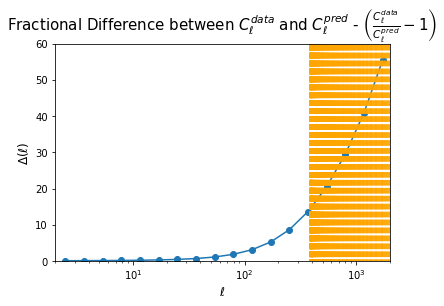

In [52]:
plt.xscale('log')
plt.plot(ell[0:18],frac[2][0:18])
plt.scatter(ell[0:18],frac[2][0:18])
plt.ylim(0,60)
plt.xlim(2,2000)

for i in np.logspace(-2,0,200):
    plt.plot((ell[13] + i*(ell[17] +3e2 - ell[13]))*np.ones(10), np.linspace(-1,60,10), "--", color = "orange")


plt.xlabel(r'$\ell$', size = 12)
plt.ylabel(r'$\Delta(\ell)$', size = 12)
plt.title(r"Fractional Difference between $C^{data}_{\ell}$ and $C^{pred}_{\ell}$ - $\left(\frac{C^{data}_{\ell}}{C^{pred}_{\ell}} - 1\right)$", size = 15)

plt.savefig('PCAexplain_4.pdf')
plt.show()

In [45]:
newdata = np.matmul(Umanual[8:], np.transpose(frac[2]))
print(len(newdata))

982


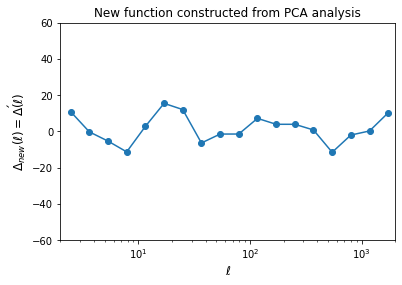

In [56]:
plt.xscale('log')
plt.plot(ell[0:18],newdata[18:36])
plt.scatter(ell[0:18],newdata[18:36])
plt.ylim(-60,60)
plt.xlim(2,2000)


plt.xlabel(r'$\ell$', size = 12)
plt.ylabel(r'$\Delta_{new}(\ell) = \Delta\'(\ell)$', size = 12)
plt.title("New function constructed from PCA analysis")

#plt.savefig('PCAexplain_3.pdf')

plt.show()

## Code I don't use

In [ ]:
""" Defining useful functions to find C_ell """

# gives index of nearest value in array
def indx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
# note: z here is an array not a single value. returns array

def Wkappag(z, c, cosmo, binn_index):
    zmax = 6.                                                              # some reasonable max z over which to integrate
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)                           # units of Mpc
    x_sample = np.linspace(z[0],zmax,int(1e3))                                # variable we integrate over
    px_sample = binning_redshiftdist(x_sample , 10)[0][binn_index]
    
    Wkg = np.zeros(len(z))     
    for i in range(len(z)):                                                # TODO is this a reasonable way of calculating this stuff?
        indx = indx_nearest(z[i], x_sample)
        x = x_sample[indx:]
        px = px_sample[indx:]
        ax = 1/(1 + x)
        chix = ccl.comoving_radial_distance(cosmo,ax)
        dchidx = c/(cosmo['H0']*ccl.h_over_h0(cosmo,ax))
        integrand = px*chiz[i]*(chix - chiz[i])/(a[i]*chix)
        Wkg[i] = scipy.integrate.simps(integrand, x)*3*cosmo['Omega_m']*(cosmo['H0']**2)/(2*c**2)
    Wkg[len(z)-1] = 0.0                                                    # The last integral is over nothing. to avoid nan
    
    return Wkg

# function that finds C_ell(ell) for a given z distribution.
# TODO: redshift normalization?

def findC_ell(cosmo, cosmoMCMC, c, ell, z, binn_index1, binn_index2):
                                                                          # find useful functs of z
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    Wkg1 = Wkappag(z, c, cosmo, binn_index1)                                    # find tomographic lens efficiency
    Wkg2 = Wkappag(z, c, cosmo, binn_index2)                                    # find tomographic lens efficiency
                                                                          # find matter power spectrum
    MPS_MCMC = np.zeros((len(z),len(ell)))
    for i in range(len(z)):                                               # MatterPowerSpec_lz[i] is for ith z
        MatterPowerSpec_lz = ccl.power.nonlin_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
        Linear_MPS = ccl.power.linear_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
        MPS_MCMC[i] = (MatterPowerSpec_lz / Linear_MPS) * ccl.power.linear_power(cosmoMCMC, (ell + 0.5)/chiz[i] , a[i])
    
    MPS_MCMC = np.transpose(MPS_MCMC)
    C_ell = np.zeros(len(ell))
    
    for i in range(len(ell)):
        integrand = (Wkg1*Wkg2)*MPS_MCMC[i]/(chiz**2)
        C_ell[i] = scipy.integrate.simps(integrand, chiz, axis = 0)
    return C_ell